# Wasserstein And Bottleneck

In this module, we will explore the Wasserstein and Bottleneck distance between persistence diagrams, and we will empirically explore their stability.

First, we do all of the necessary imports


In [1]:
#Do all of the imports and setup inline plotting
import time
import numpy as np
from scipy import sparse
from ripser import ripser, plot_dgms
from DGMTools import *

%matplotlib notebook
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

## Example 1: Noisy Circle Matching

Let's first do a simple example of matching the H1 persistence diagram for points sampled from a circle to the H1 diagram from a noisy version of that circle

#### Questions
* What happens when you increase the noise?  Is there an amount of noise where the bottleneck point gets matched to a different point than the same point in the Wasserstein matching?

In [2]:
%matplotlib inline

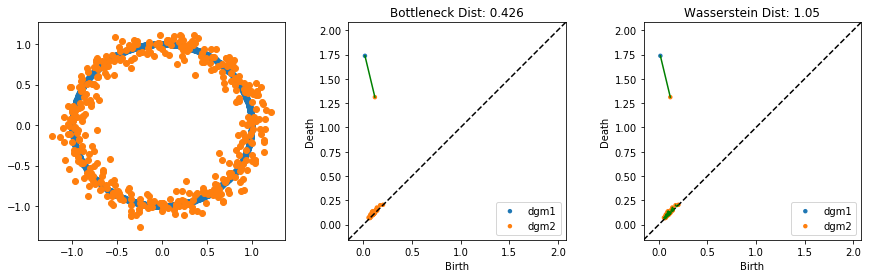

In [3]:

# First, sample points from a circle
N = 400
t = np.linspace(0, 2*np.pi, N+1)[0:N]
X = np.zeros((N, 2))
X[:, 0] = np.cos(t)
X[:, 1] = np.sin(t)
I1 = ripser(X)['dgms'][1]

# Now, add noise to the points
X2 = X + 0.1*np.random.randn(N, 2)
I2 = ripser(X2)['dgms'][1]

# Perform the matching
(matchidxb, bdist, bD) = getBottleneckDist(I1, I2)
(matchidxw, wdist, wD) = getWassersteinDist(I1, I2)

plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(X2[:, 0], X2[:, 1])
plt.subplot(132)
plotBottleneckMatching(I1, I2, matchidxb, bD)
plt.title("Bottleneck Dist: %.3g"%bdist)
plt.subplot(133)
plotWassersteinMatching(I1, I2, matchidxw)
plt.title("Wasserstein Dist: %.3g"%wdist)
plt.show()

## Example 2: Stability of Noisy Sublevelset Filtration

We will now explore a different example of a <i>sublevelset filtration</i> or a ''lower star filtration'' of a 1D time series, compared to the lower star filtration of a time series with some noise added.

First, we define a sparse distance matrix which represents the lower star filtration


In [4]:
def getLowerStarTimeSeriesD(x):
    N = x.size
    # Add edges between adjacent points in the time series, with the "distance" 
    # along the edge equal to the max value of the points it connects
    I = np.arange(N-1)
    J = np.arange(1, N)
    V = np.maximum(x[0:-1], x[1::])
    # Add vertex birth times along the diagonal of the distance matrix
    I = np.concatenate((I, np.arange(N)))
    J = np.concatenate((J, np.arange(N)))
    V = np.concatenate((V, x))
    #Create the sparse distance matrix
    D = sparse.coo_matrix((V, (I, J)), shape=(N, N)).tocsr()
    return D

Now, we can perfor sublevelset filtrations on a time series by itself and with a small amount of noise added

#### Exercise / Question

* In the example below, increase the number of samples, while keeping the standard deviation of the noise fixed.  Does one of the distances seem more stable than the other?  Can you explain in this instance why?

Elapsed time Wasserstein: 0.0567
Elapsed time Bottleneck: 1.7


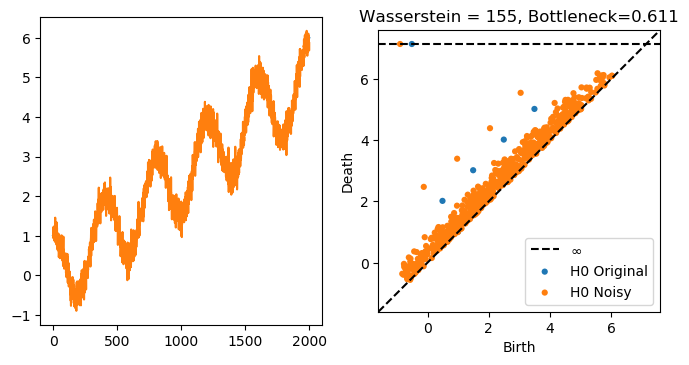

In [5]:
NSamples = 2000
t = np.linspace(0, 5, NSamples)
x = np.cos(2*np.pi*t) + t
y = x + 0.2*np.random.randn(NSamples)

Dx = getLowerStarTimeSeriesD(x)
Dy = getLowerStarTimeSeriesD(y)
Ix = ripser(Dx, distance_matrix=True, maxdim=0)['dgms'][0]
Iy = ripser(Dy, distance_matrix=True, maxdim=0)['dgms'][0]


plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(x)
plt.plot(y)
plt.subplot(122)
plot_dgms([Ix, Iy], labels = ['H0 Original', 'H0 Noisy'])

#Remove point at infinity before bottleneck/wasserstein
Ix = Ix[np.isfinite(Ix[:, 1]), :]
Iy = Iy[np.isfinite(Iy[:, 1]), :]

tic = time.time()
(_, dw, _) = getWassersteinDist(Ix, Iy)
print("Elapsed time Wasserstein: %.3g"%(time.time()-tic))
tic = time.time()
(_, db, _) = getBottleneckDist(Ix, Iy)
print("Elapsed time Bottleneck: %.3g"%(time.time()-tic))
plt.title("Wasserstein = %.3g, Bottleneck=%.3g"%(dw, db))
plt.show()